In [1]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
mpl.style.use('../../paper.mcstyle')
import matplotlib.cm as cm



from ili.validation.metrics import PosteriorCoverage
from CASBI.utils import create_template_library as ctl
from CASBI.sbi.inference import train_inference


gpu_index = 6  # replace with your desired GPU index
torch.cuda.set_device(gpu_index)
device = f"cuda:{gpu_index}"

In [2]:
#paper column width is 397.48499pt
pt = 1/72.27
column_width = 397.48499*pt
aspect_ratio = 1.61803398875
my_width = column_width
my_height = my_width/aspect_ratio

In [3]:
data = pd.read_parquet('../../data/dataframe.parquet')
hist_file_path = '../../data/histograms/'
M_tot = 1.4*1e9
alpha = 1.25
test_set_sample = 100
training_set_sample = 1_000


#generate the input for the creation of the training and test template library 
galaxy_name, mass_nn, infall_time, m_max, m_min = ctl.template_input(data, M_tot=1.4*1e9)

    
#generate the test library
flattened_hist_list_test, flattened_param_list_test, galaxies_test_name = ctl.gen_template_library(hist_file_path, test_set_sample, galaxy_name, M_tot, mass_nn, infall_time, m_max, m_min, alpha)

#generate the training library
flattened_hist_list, flattened_param_list, galaxies_train_name = ctl.gen_template_library(hist_file_path, training_set_sample, galaxy_name, M_tot, mass_nn, infall_time, m_max, m_min, alpha, galaxies_test_name)

#rebalance the training set to avoid overfitting on high N
mask = [flattened_hist_list[:, 1, 0, 0] < np.random.uniform(low=0, high=100, size=len(flattened_hist_list[:, 1, 0, 0])) ][0] 
training_x = flattened_hist_list[mask]
training_theta = flattened_param_list[mask]


unique galaxy in the test set that are not empty: 100
unique galaxy in the trainig set that are not empty: 997


In [4]:
print(flattened_hist_list.shape)
print(flattened_param_list.shape)

(48202, 3, 64, 64)
(48202, 4)


In [5]:
#test set for 
test_x = torch.from_numpy(flattened_hist_list_test).float()
test_theta = torch.from_numpy(flattened_param_list_test).float()

#training set 
x = torch.from_numpy(training_x).float()
theta = torch.from_numpy(training_theta).float()

In [6]:
#training the model
posterior_ensemble, summaries = train_inference(x, theta)

35164


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 4.
411 epochs [15:27,  2.26s/ epochs, loss=-0.483, loss_val=-0.431]   
INFO:root:Training model 2 / 4.
643 epochs [24:16,  2.26s/ epochs, loss=-0.548, loss_val=-0.469]   
INFO:root:Training model 3 / 4.
584 epochs [22:01,  2.26s/ epochs, loss=-0.522, loss_val=-0.514]   
INFO:root:Training model 4 / 4.
739 epochs [28:00,  2.27s/ epochs, loss=-0.681, loss_val=-0.649]  
INFO:root:It took 5391.918259143829 seconds to train models.
INFO:root:Saving model to .


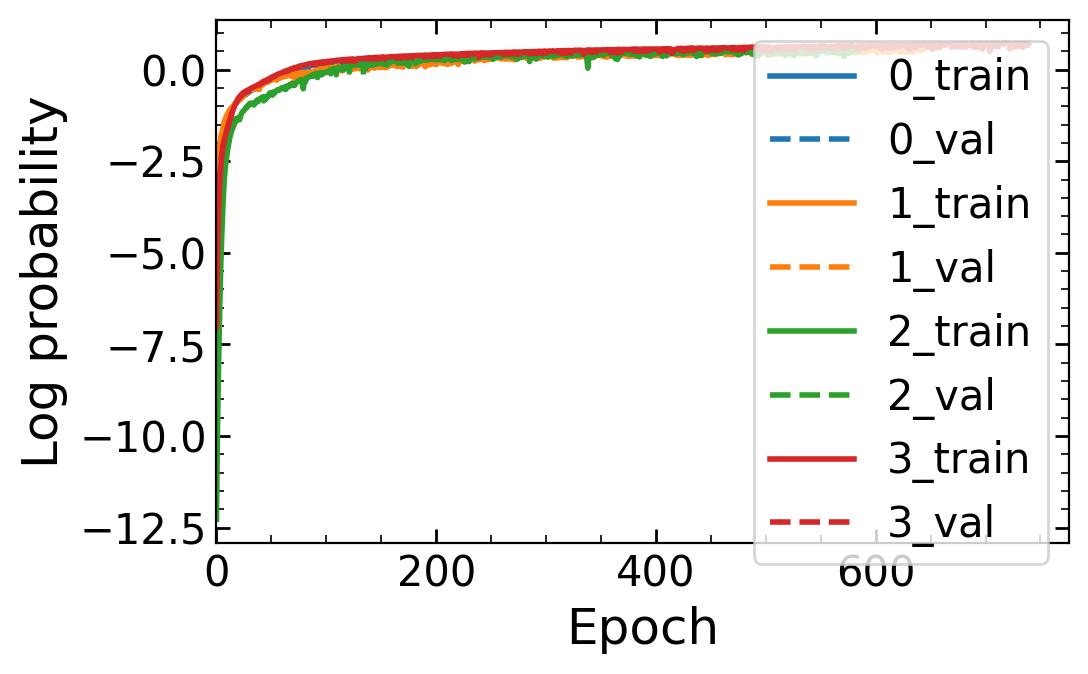

In [7]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(my_width,my_height))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()
fig.savefig('./train_val_loss.png')

/tmp/ipykernel_877248/2495008588.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # 'viridis' is the colormap name


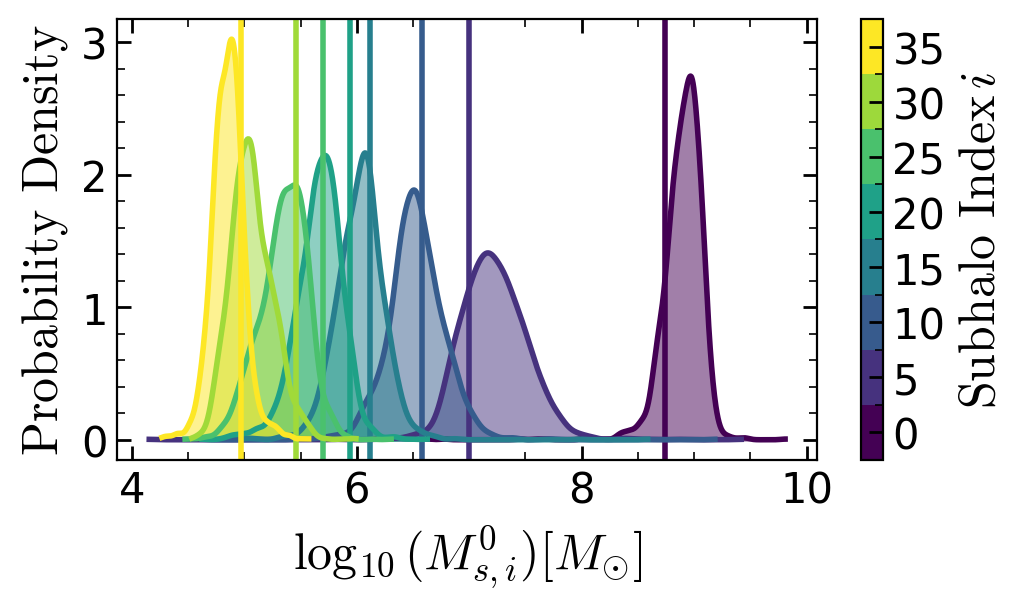

In [9]:
# Plot figure 2 of the paper, model output for the first galaxy (j=0) of the test set

# Create a colormap
cmap = cm.get_cmap('viridis')  # 'viridis' is the colormap name

# Create a list of colors
colors = [cmap(i) for i in np.linspace(0, 1, 8)]  # Replace 8 with the number of colors you want

fig, ax = plt.subplots(1, 1, figsize=(my_width,my_height))
for (c,i) in enumerate(range(40)[::5]):
    mask_obs =  [(test_x[:, 1, 0, 0]==i)&(test_x[:, 2, 0, 0]==0)] #i is the subhalo index, 0 is the galaxy index
    samples = posterior_ensemble.sample((2_000,), x=test_x[mask_obs].to(device), show_progress_bars=False) 
    samples =  samples[:, 0].cpu().numpy()
    density = gaussian_kde(samples)
    density_val = density(np.linspace(min(samples), max(samples), 1000))
    ax.plot(np.linspace(min(samples), max(samples), 1000), density_val, color=colors[c])    
    ax.fill_between(np.linspace(min(samples), max(samples), 1000), density_val, alpha=0.5, color=colors[c])
    
    mask_parameters = [(test_theta[:, 2]==i)&(test_theta[:, 3]==0)] #i is the subhalo index, 0 is the galaxy index
    ax.axvline(x=test_theta[mask_parameters][0, 0].cpu().numpy(), color=colors[c])

ax.set_xlabel(r'$\log_{10}(M_{s,i}^0) [M_{\odot}]$')
ax.set_ylabel(r'$\text{Probability Density}$')

#Colorbar 
norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, 8, 1), ncolors=cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  

cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(8))
cbar.ax.set_yticklabels([f'{i*5}' for i in range(8)])  # Set the labels for the colorbar
cbar.set_label(r'$\text{Subhalo Index} \, i$')
fig.tight_layout()
plt.savefig('./figure_1.pdf')

100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


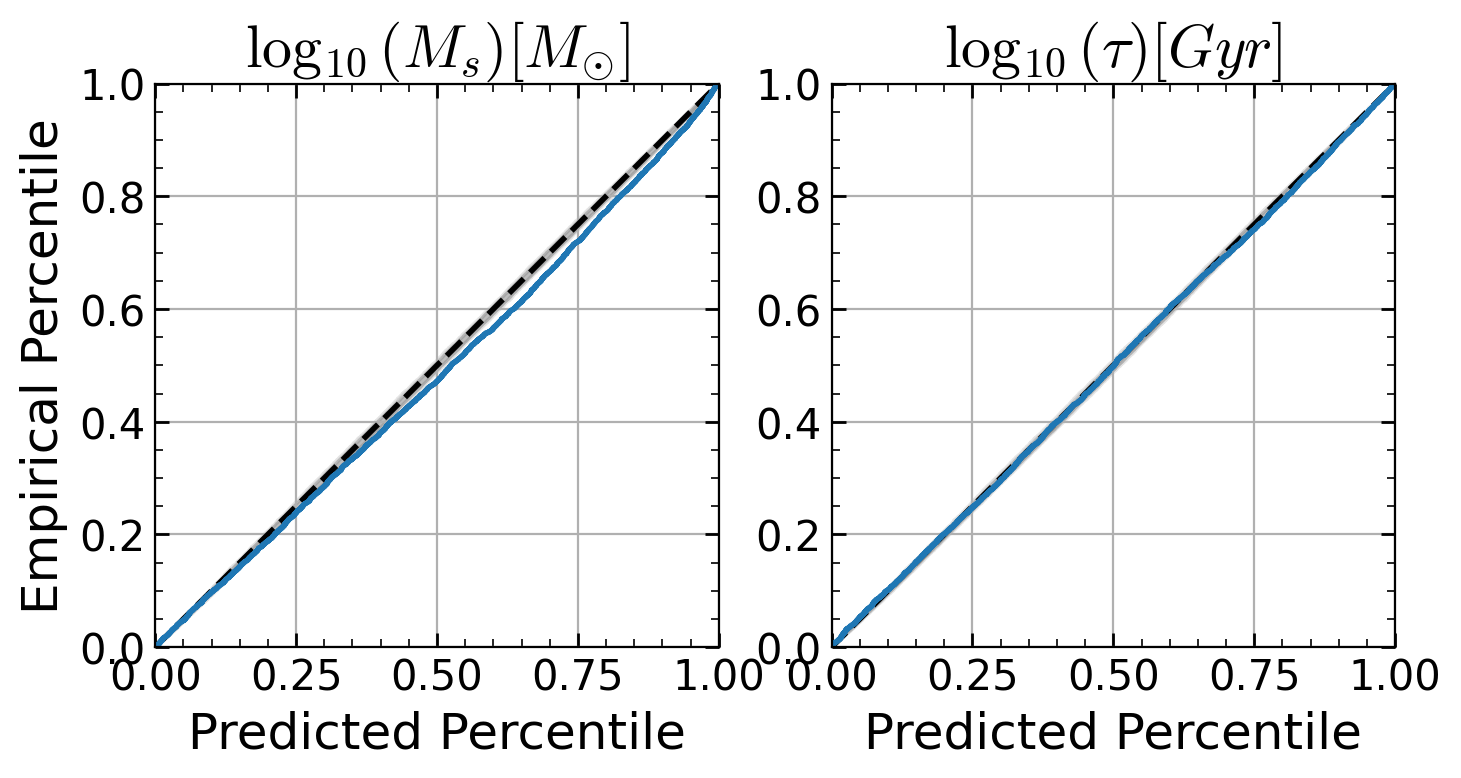

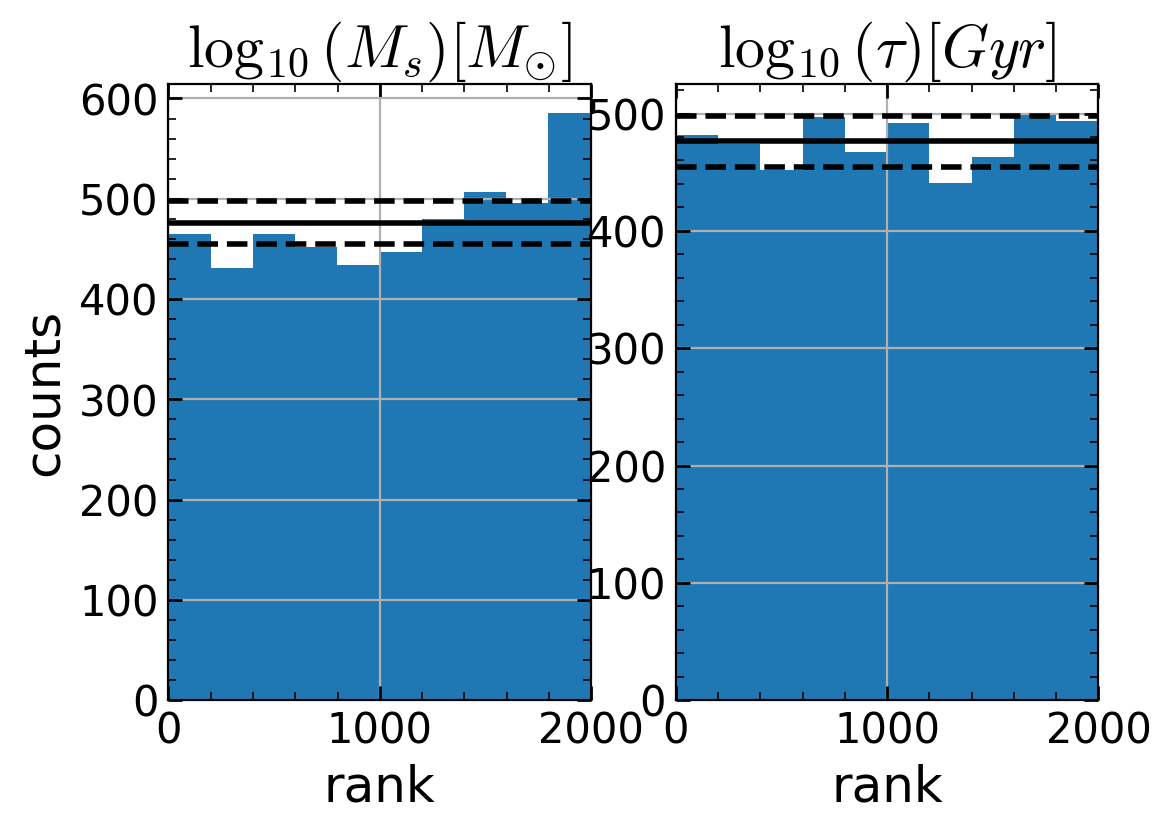

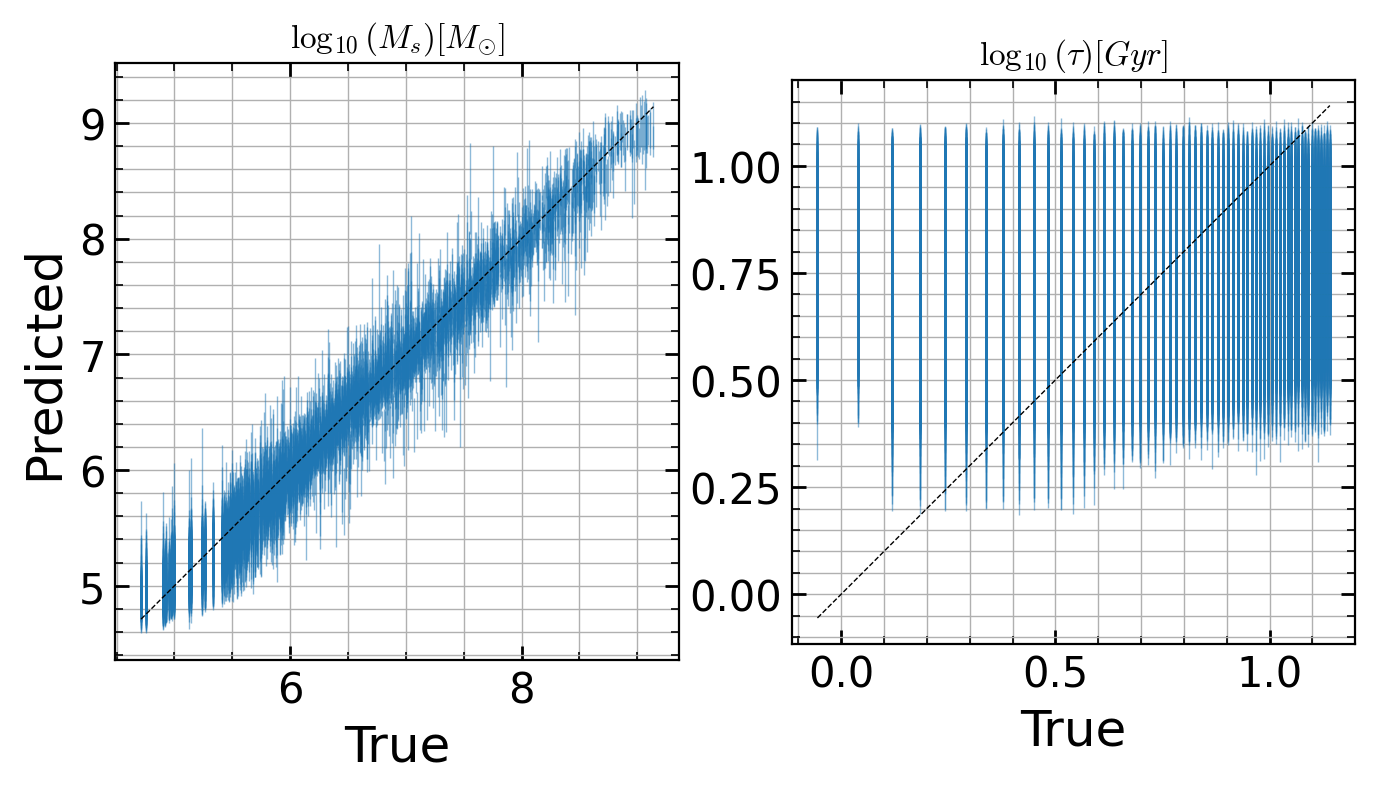

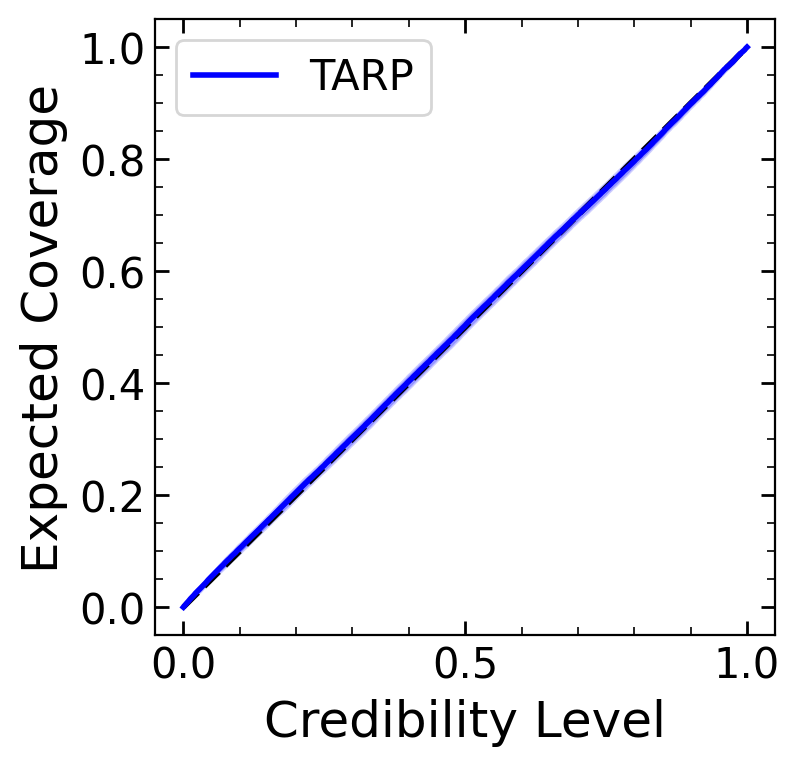

In [11]:
# Plot figure 3 of the paper, model evaluation on the test set, we directly use the function from the ltu-ili package

plot_hist = ["coverage", "histogram", "predictions", "tarp"]
metric = PosteriorCoverage(
    num_samples=2_000, sample_method='direct',
    labels=[rf'$\log_{{10}}(M_{{s}}) [M_{{\odot}}]$', rf'$\log_{{10}}(\tau) [Gyr]$'], plot_list = plot_hist
)

fig = metric(
    posterior=posterior_ensemble,
    x=test_x, theta=test_theta[:, :2])

fig[0].savefig('./figure_3b.pdf')
fig[1].savefig('./predictions.pdf')
fig[2].savefig('./figure_3a.pdf')
fig[3].savefig('./figure_3c.pdf')